# Time Series Analysis - ARIMA Model

## Overview
ARIMA (AutoRegressive Integrated Moving Average) is a powerful forecasting method for stationary time series.

### Components:
- **AR(p)**: AutoRegressive - uses past values to predict future
- **I(d)**: Integrated - differencing to achieve stationarity
- **MA(q)**: Moving Average - uses past forecast errors

### Model Notation: ARIMA(p, d, q)
- **p**: Number of lag observations (AR order)
- **d**: Degree of differencing (Integration order)
- **q**: Size of moving average window (MA order)

### Common ARIMA Models in Finance:
- ARIMA(1,0,0): Simple AR - mean reversion
- ARIMA(0,1,0): Random walk - stock prices
- ARIMA(1,1,1): Balanced model - general forecasting
- ARIMA(2,1,2): Complex series - economic indicators

---

In [ ]:
# ═══════════════════════════════════════════════════════════════
# FICHE MÉMO ARIMA
# ═══════════════════════════════════════════════════════════════
# ARIMA = Modèle pour séries temporelles stationnaires
#
# STATIONNARITÉ
#   Stationnaire     : E[X] constante, Var constante, Cov stable
#   Non-stationnaire : E[X] variable, Var(t), Cov variable
#   Test : ACF décroît lentement → non-stationnaire → différencier
#
# COMPOSANTES
#   AR (p) : Le futur dépend du passé (autorégressif)
#   I  (d) : Différenciation pour rendre stationnaire
#   MA (q) : Correction avec erreurs passées
#
# TROUVER (p, d, q)
#   p → PACF (coupe après lag p)
#   d → Test ADF (p>0.05 → d=1, sinon d=0)
#   q → ACF (coupe après lag q)
#
# MODÈLES COURANTS EN FINANCE
#   ARIMA(1,0,0) → Returns stationnaires simples
#   ARIMA(0,1,0) → Random walk (prix)
#   ARIMA(1,1,1) → Modèle équilibré standard
#   ARIMA(2,1,2) → Séries complexes
# ═══════════════════════════════════════════════════════════════

In [ ]:
# ═══════════════════════════════════════════════════════════════
# FICHE MÉMO ACF (AutoCorrelation Function)
# ═══════════════════════════════════════════════════════════════
# ACF = Corrélation entre Xt et Xt-k (totale, avec effets indirects)
# ρ(k) = Corr(Xt, Xt-k) ∈ [-1, 1]
#
# INTERPRÉTATION
#   ρ = +1 : Corrélation parfaite positive
#   ρ = 0  : Pas de corrélation
#   ρ = -1 : Corrélation parfaite négative
#
# PATTERNS ACF
#   Décroissance lente       → Non-stationnaire
#   Pic lag 1 puis chute     → AR(1)
#   Oscillations             → Saisonnalité
#   Bruit blanc              → Pas de structure
#
# UTILITÉ
#   ✓ Tester stationnarité
#   ✓ Identifier q (MA order)
#   ✓ Vérifier résidus du modèle
#   ✓ Détecter saisonnalité
# ═══════════════════════════════════════════════════════════════

In [ ]:
# ═══════════════════════════════════════════════════════════════
# FICHE MÉMO PACF (Partial AutoCorrelation Function)
# ═══════════════════════════════════════════════════════════════
# PACF = Corrélation directe entre Xt et Xt-k (sans effets intermédiaires)
# Différence : ACF = totale / PACF = directe uniquement
#
# PATTERNS PACF
#   Coupure nette après lag p    → AR(p)
#   Décroissance exponentielle   → MA(q)
#   Oscillations amorties        → ARMA mixte
#   Tous lags non-significatifs  → Bruit blanc
#
# ACF vs PACF : IDENTIFIER (p, q)
#   AR(p)      : ACF décroît  / PACF coupe à p
#   MA(q)      : ACF coupe à q / PACF décroît
#   ARMA(p,q)  : Les deux décroissent
#
# RÈGLE PRATIQUE
#   p (AR) → Regarde où PACF coupe
#   q (MA) → Regarde où ACF coupe
#
# UTILITÉ
#   ✓ Identifier ordre p du modèle AR
#   ✓ Distinguer AR vs MA
#   ✓ Optimiser paramètres ARIMA
# ═══════════════════════════════════════════════════════════════

## 1. Setup & Data Loading

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Time series specific
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm


%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)

In [7]:
# Load dataset - Airline Passengers (classic time series)
airline = pd.read_csv('airline_passengers.csv', index_col='Month')
airline.dropna(inplace=True)

# Convert to proper datetime
airline.index = pd.to_datetime(airline.index)
airline.head()


print("Dataset loaded:")
print(f"Period: {series.index.min()} to {series.index.max()}")
print(f"Length: {len(series)} observations")
display(airline.head())

Dataset loaded:
Period: 1949-01-01 00:00:00 to 1960-12-01 00:00:00
Length: 144 observations


,Thousands of Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


## 2. Check for Stationarity (Critical Step)

In [8]:
# Augmented Dickey-Fuller Test for stationarity
# H0: Series is non-stationary (has unit root)
# H1: Series is stationary
# If p-value < 0.05 → Reject H0 → Series is stationary

def adf_test(series, name=''):
    """Perform Augmented Dickey-Fuller test"""
    result = adfuller(series.dropna())
    print(f'\nADF Test Results - {name}')
    print('='*50)
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'  {key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print(f"\n✓ Stationary (p-value = {result[1]:.4f} < 0.05)")
        print("  → Can use ARIMA with d=0")
    else:
        print(f"\n✗ Non-stationary (p-value = {result[1]:.4f} > 0.05)")
        print("  → Need differencing (d=1 or d=2)")
    return result[1]

# Test original series
p_value_original = adf_test(series, 'Original Series')


ADF Test Results - Original Series
ADF Statistic: 0.8154
p-value: 0.9919
Critical Values:
  1%: -3.482
  5%: -2.884
  10%: -2.579

✗ Non-stationary (p-value = 0.9919 > 0.05)
  → Need differencing (d=1 or d=2)


## 3. Make Series Stationary (Differencing)

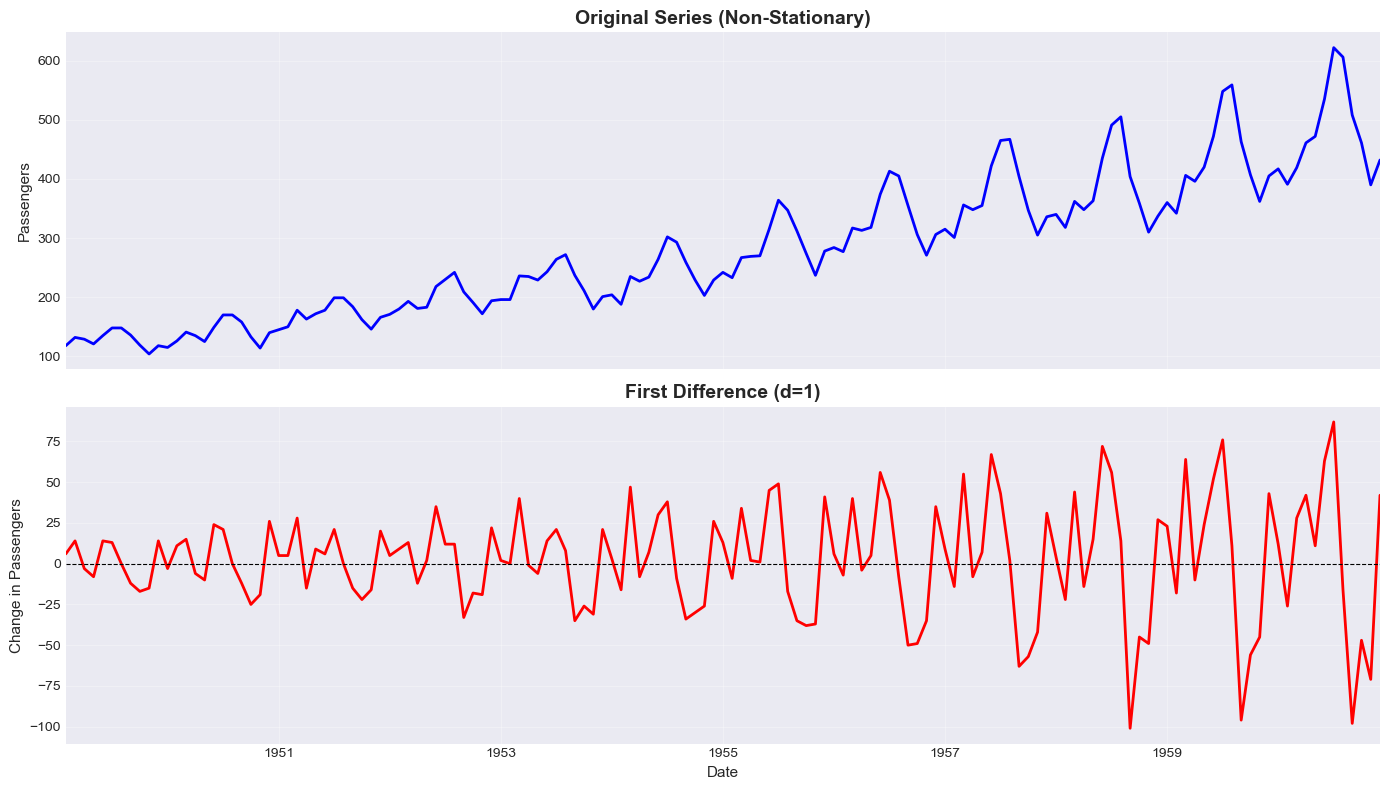


ADF Test Results - First Differenced Series
ADF Statistic: -2.8293
p-value: 0.0542
Critical Values:
  1%: -3.482
  5%: -2.884
  10%: -2.579

✗ Non-stationary (p-value = 0.0542 > 0.05)
  → Need differencing (d=1 or d=2)


In [9]:
# Apply differencing to remove trend
# First difference: Y'_t = Y_t - Y_{t-1}
series_diff = series.diff().dropna()

# Plot original vs differenced
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Original
series.plot(ax=axes[0], color='blue', linewidth=2)
axes[0].set_title('Original Series (Non-Stationary)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Passengers', fontsize=11)
axes[0].grid(True, alpha=0.3)

# Differenced
series_diff.plot(ax=axes[1], color='red', linewidth=2)
axes[1].set_title('First Difference (d=1)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Change in Passengers', fontsize=11)
axes[1].set_xlabel('Date', fontsize=11)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Test differenced series
p_value_diff = adf_test(series_diff, 'First Differenced Series')

## 4. Identify p and q using ACF/PACF

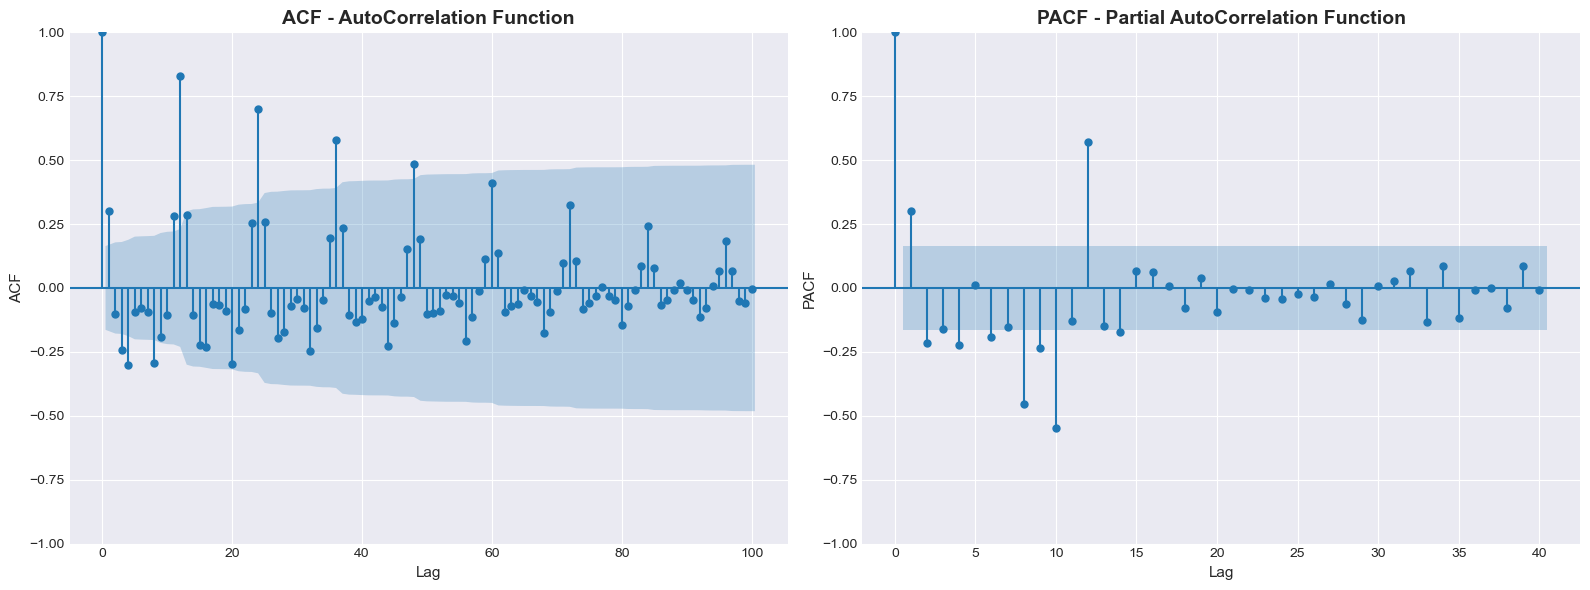


How to read ACF/PACF:

1. Look where ACF cuts off → This is q (MA order)
2. Look where PACF cuts off → This is p (AR order)
3. Blue shaded area = 95% confidence interval
4. Spikes outside blue area = significant correlations

Common patterns:
- AR(p): PACF cuts at lag p, ACF decays gradually
- MA(q): ACF cuts at lag q, PACF decays gradually
- ARMA(p,q): Both decay gradually


In [27]:
# Plot ACF and PACF to determine ARIMA orders
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ACF plot - identifies q (MA order)
plot_acf(series_diff, lags=100, ax=axes[0])
axes[0].set_title('ACF - AutoCorrelation Function', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Lag', fontsize=11)
axes[0].set_ylabel('ACF', fontsize=11)

# PACF plot - identifies p (AR order)
plot_pacf(series_diff, lags=40, ax=axes[1])
axes[1].set_title('PACF - Partial AutoCorrelation Function', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Lag', fontsize=11)
axes[1].set_ylabel('PACF', fontsize=11)

plt.tight_layout()
plt.show()

print("\nHow to read ACF/PACF:")
print("="*50)
print("\n1. Look where ACF cuts off → This is q (MA order)")
print("2. Look where PACF cuts off → This is p (AR order)")
print("3. Blue shaded area = 95% confidence interval")
print("4. Spikes outside blue area = significant correlations")
print("\nCommon patterns:")
print("- AR(p): PACF cuts at lag p, ACF decays gradually")
print("- MA(q): ACF cuts at lag q, PACF decays gradually")
print("- ARMA(p,q): Both decay gradually")

## 5. Fit ARIMA Model

In [11]:
# Based on ACF/PACF analysis, let's try ARIMA(1,1,1)
# p=1: One AR term (PACF shows significance at lag 1)
# d=1: First differencing (we already confirmed series needs it)
# q=1: One MA term (ACF shows significance at lag 1)

# Fit model
model = ARIMA(series, order=(1, 1, 1))
model_fit = model.fit()

# Display model summary
print(model_fit.summary())

# Key metrics to check:
print("\nKey Model Diagnostics:")
print("="*50)
print(f"AIC (Akaike Information Criterion): {model_fit.aic:.2f}")
print(f"BIC (Bayesian Information Criterion): {model_fit.bic:.2f}")
print("  → Lower AIC/BIC = better model")
print("\nCoefficients:")
print(model_fit.params)

C:\Users\Utilisateur\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Utilisateur\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Utilisateur\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                  SARIMAX Results                                  
Dep. Variable:     Thousands of Passengers   No. Observations:                  144
Model:                      ARIMA(1, 1, 1)   Log Likelihood                -694.341
Date:                     Fri, 13 Feb 2026   AIC                           1394.683
Time:                             11:01:46   BIC                           1403.571
Sample:                         01-01-1949   HQIC                          1398.294
                              - 12-01-1960                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4742      0.123     -3.847      0.000      -0.716      -0.233
ma.L1          0.8635      0.078     11.051      0.000       0.710       1.017
sigma2      

## 6. Model Diagnostics (Residual Analysis)

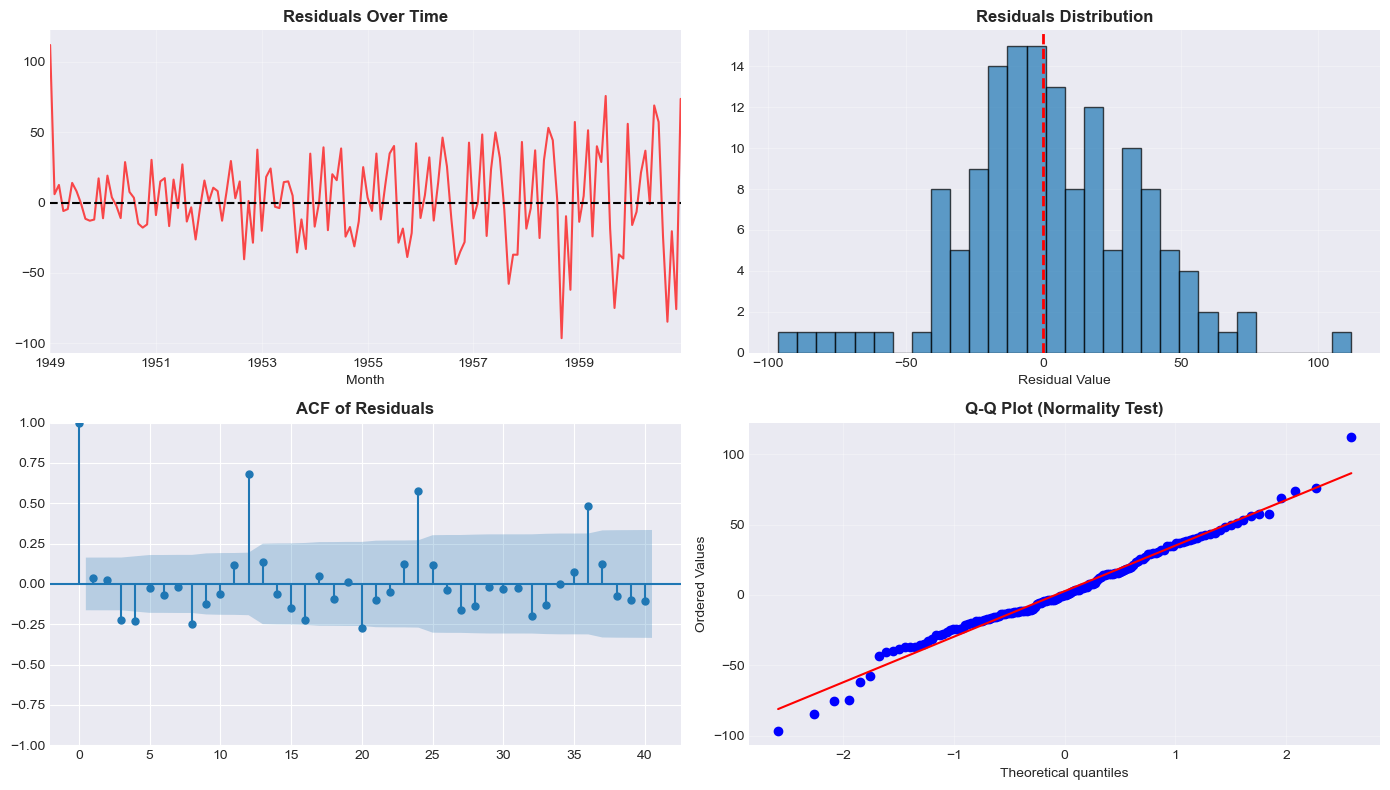


Residual Statistics:
Mean: 2.7054 (should be ≈ 0)
Std Dev: 32.2932
Skewness: 0.0202 (should be ≈ 0)
Kurtosis: 0.9335 (should be ≈ 0)

→ Good residuals = random noise with no patterns


In [12]:
# Check if residuals are white noise (good model)
# Good residuals should:
# 1. Have mean ≈ 0
# 2. Have constant variance
# 3. Be normally distributed
# 4. Show no autocorrelation

residuals = model_fit.resid

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Residuals over time
residuals.plot(ax=axes[0, 0], color='red', alpha=0.7)
axes[0, 0].set_title('Residuals Over Time', fontsize=12, fontweight='bold')
axes[0, 0].axhline(y=0, color='black', linestyle='--')
axes[0, 0].grid(True, alpha=0.3)

# Residuals histogram
residuals.hist(bins=30, ax=axes[0, 1], edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Residuals Distribution', fontsize=12, fontweight='bold')
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Residual Value')
axes[0, 1].grid(True, alpha=0.3)

# ACF of residuals
plot_acf(residuals.dropna(), lags=40, ax=axes[1, 0])
axes[1, 0].set_title('ACF of Residuals', fontsize=12, fontweight='bold')

# Q-Q plot (normality test)
from scipy import stats
stats.probplot(residuals.dropna(), dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Normality Test)', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nResidual Statistics:")
print("="*50)
print(f"Mean: {residuals.mean():.4f} (should be ≈ 0)")
print(f"Std Dev: {residuals.std():.4f}")
print(f"Skewness: {residuals.skew():.4f} (should be ≈ 0)")
print(f"Kurtosis: {residuals.kurtosis():.4f} (should be ≈ 0)")
print("\n→ Good residuals = random noise with no patterns")

## 7. Forecasting

Training set: 115 observations (1949-01-01 00:00:00 to 1958-07-01 00:00:00)
Test set: 29 observations (1958-08-01 00:00:00 to 1960-12-01 00:00:00)


C:\Users\Utilisateur\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Utilisateur\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Utilisateur\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


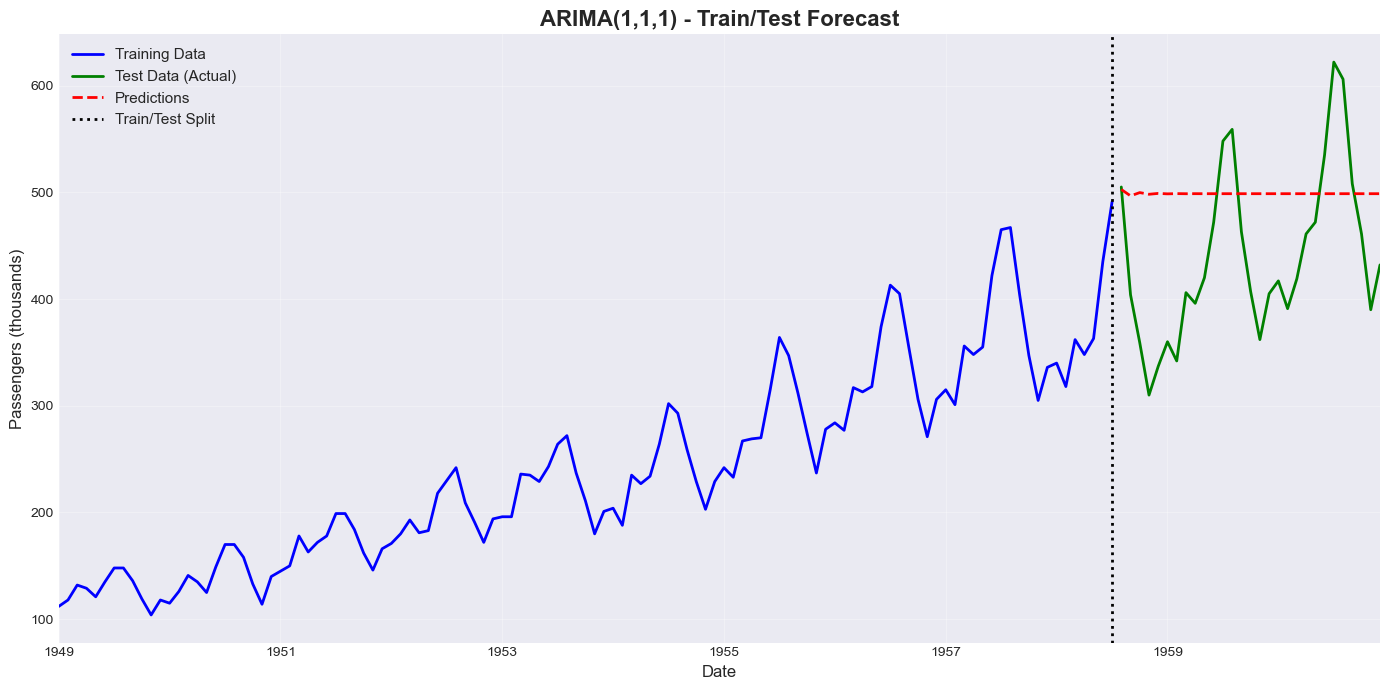


Forecast Performance Metrics:
Mean Squared Error (MSE):  9506.18
Root Mean Squared Error (RMSE): 97.50
Mean Absolute Error (MAE): 85.25

Actual vs Predicted (First 6 periods):


,Actual,Predicted,Error
Month,,,
1958-08-01,505.0,502.649601,2.350399
1958-09-01,404.0,496.695602,-92.695602
1958-10-01,359.0,499.738634,-140.738634
1958-11-01,310.0,498.183369,-188.183369
1958-12-01,337.0,498.978250,-161.978250
1959-01-01,360.0,498.571994,-138.571994


In [28]:
# ═══════════════════════════════════════════════════════════════
# FORECASTING - Train/Test Split Approach
# ═══════════════════════════════════════════════════════════════

# Split data into train and test sets
# Train on first 80% of data, test on last 20%
train_size = int(len(series) * 0.8)
train = series[:train_size]
test = series[train_size:]

print(f"Training set: {len(train)} observations ({series.index[0]} to {train.index[-1]})")
print(f"Test set: {len(test)} observations ({test.index[0]} to {series.index[-1]})")

# Fit ARIMA model on training data
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Get predictions
# start = index of first prediction (start of test set)
# end = index of last prediction (end of test set)
# dynamic=False means predictions use actual historical values (one-step-ahead)
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

# Create a series with proper index for plotting
predictions_series = pd.Series(predictions.values, index=test.index)

# Plot results
fig, ax = plt.subplots(figsize=(14, 7))

# Plot training data
train.plot(ax=ax, label='Training Data', linewidth=2, color='blue')

# Plot test data (actual values)
test.plot(ax=ax, label='Test Data (Actual)', linewidth=2, color='green')

# Plot predictions
predictions_series.plot(ax=ax, label='Predictions', linewidth=2, color='red', linestyle='--')

# Add vertical line to show train/test split
ax.axvline(x=train.index[-1], color='black', linestyle=':', linewidth=2, label='Train/Test Split')

ax.set_title('ARIMA(1,1,1) - Train/Test Forecast', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Passengers (thousands)', fontsize=12)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate error metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(test, predictions_series)
rmse = math.sqrt(mse)
mae = mean_absolute_error(test, predictions_series)

print("\nForecast Performance Metrics:")
print("="*60)
print(f"Mean Squared Error (MSE):  {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Show actual vs predicted values
print("\nActual vs Predicted (First 6 periods):")
print("="*60)
comparison_df = pd.DataFrame({
    'Actual': test[:6].values,
    'Predicted': predictions_series[:6].values,
    'Error': (test[:6].values - predictions_series[:6].values)
}, index=test[:6].index)
display(comparison_df)

## 8. Key Takeaways & Best Practices

### ARIMA Workflow:
1. **Check stationarity** (ADF test)
2. **Make stationary** (differencing if needed)
3. **Identify p, q** (ACF/PACF plots)
4. **Fit model** (ARIMA)
5. **Diagnose residuals** (should be white noise)
6. **Forecast** (with confidence intervals)

### Choosing ARIMA Orders:

**d (Differencing)**:
- d=0: Series already stationary
- d=1: Linear trend removed (most common)
- d=2: Quadratic trend (rare)

**p (AR order)**:
- Look at PACF cutoff
- Start with p=1 or p=2
- Higher p = more complex memory

**q (MA order)**:
- Look at ACF cutoff
- Start with q=1 or q=2
- Higher q = more error correction

---

### Applications in Finance:
Stock price forecasting (with caution - often random walk)
Economic indicators (GDP, inflation, unemployment)
Interest rate modeling
Demand forecasting (inventory management)
Risk metrics (VaR components)

**Important**: ARIMA assumes linear relationships. For complex, non-linear series, consider ML methods (LSTM, XGBoost).

---
*End of Time Series Analysis series.*